# Лабораторная работа №2
Найти приближенное решение уравнения Пуассона в прямоугольной области. Для решения системы линейных уравнений использовать метод минимальных невязок.
## Вариант №11
Найти решение уравнения Пуассона с граничными условиями Неймана по оси $x$ и периодическими условиями вдоль оси $y$:
\begin{equation*}
\begin{cases}
    \Delta u = (9x-10)e^{-5x}\sin{4y}, \ \ 0 < x < 1,\ \ 0 < y < \pi \\
    \displaystyle u_x(0, y) = \sin{4y},\ \ u_x(1, y) = -\frac{4}{e^5}\sin{4y} \\
    u(x, y + \pi) = u(x, y) 
\end{cases}
\end{equation*}

Точное решение:
$$ u_0(x, y) = xe^{-5x}\sin{4y} $$

Обозначим $\displaystyle \varphi_L(y) = -\sin{4y}, \ \ \varphi_R(y) = -\frac{4}{e^5}\sin{4y}, \ \ f(x, y) = -(9x-10)e^{-5x}\sin{4y}$

Перейдем к разностной схеме:

$ \displaystyle (Lu)_{i,j} = [i > 1] \frac{u_{i,j} - u_{i-1, j}}{h_x^2} + [i < n_x] \frac{u_{i,j} - u_{i+1,j}}{h_x^2} + [j > 1] \frac{u_{i,j} - u_{i, j-1}}{h_y^2} + [j < n_y] \frac{u_{i,j} - u_{i, j+1}}{h_y^2} +$

$\displaystyle \ \ \ \ \ \ \ \ \ \ \ \ \ \ + [j = 1]\frac{u_{i, j} - u_{i, n_y}}{h_y^2} + [j = n_y]\frac{u_{i,j} - u_{i, 1}}{h_y^2}$

$\displaystyle (F)_{i,j} = f_{i,j} + [i = 1]\frac{\varphi_{Lj}}{h_x} + [i = x_n]\frac{\varphi_{Rj}}{h_x}$

Импортируем необходимые библиотеки

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
%matplotlib inline

Зададим характерный размер, и получим сетку для решения задачи:

In [12]:
h_0 = 0.01

l_x, l_y = 1, np.pi
n_x, n_y = int(np.round(l_x / h_0)), int(np.round(l_y / h_0))
h_x, h_y = l_x / n_x, l_y / n_y
x = np.linspace(h_x / 2, l_x - h_x / 2, n_x)
y = np.linspace(h_y / 2, l_y - h_y / 2, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')

Введем функции из задачи:

In [13]:
def analitical(x, y):
    res =  x * np.exp(-5 * x) * np.sin(4 * y)
    return res - res.mean()

def f(x, y): 
    return -(9 * x - 10) * np.exp(-5 * x) * np.sin(4 * y)

def phi_L(y):
    return -np.sin(4 * y)

def phi_R(y):
    return -4 * np.exp(-5) * np.sin(4 * y)

Введем функции для сеточного оператора и для правой части:

In [14]:
def RHS(X, Y, h_x, h_y):
    res = f(X, Y)
    res[0, :] += phi_L(Y[0, :]) / h_x
    res[-1,:] += phi_R(Y[-1,:]) / h_x
    return res - res.mean()

def OpL(u, h_x, h_y):
    res = np.zeros_like(u)
    res[1:, :] += (u[1 :,:] - u[:-1,:]) / h_x ** 2 # i > 1
    res[:-1,:] += (u[:-1,:] - u[1 :,:]) / h_x ** 2 # i < n_x
    res[:, 1:] += (u[:, 1:] - u[:,:-1]) / h_y ** 2 # j > 1
    res[:,:-1] += (u[:,:-1] - u[:,1 :]) / h_y ** 2 # j < n_y
    res[:, 0] += (u[:, 0] - u[:,-1]) / h_y ** 2    # j = 1
    res[:,-1] += (u[:,-1] - u[:, 0]) / h_y ** 2    # j = n_y
    return res

По заданию систему уравнений нужно решать при помощи метода минимальных невязок

$$ \frac{u^{k+1} - u^k}{\tau^{k+1}} + Lu^k = F $$

$$ r^k = Lu^k - F$$

$$ \tau^{k + 1} = \frac{(Lr^k, r^k)}{||Lr^k||^2}$$

$$ u^{k+1} = \frac{(Lr^k, r^k)}{||Lr^k||^2} (F - Lu^k) + u^k$$

In [15]:
u = np.zeros_like(X) # начальное приближение
epsilon = 1e-6
F = RHS(X, Y, h_x, h_y)
r = OpL(u, h_x, h_y) - F

while np.abs((r**2).sum() > epsilon):
    Lr = OpL(r, h_x, h_y)
    u += Lr.ravel().dot(r.ravel()) / LA.norm(Lr)**2 * (F - OpL(u, h_x, h_y))
    u -= u.mean() # нормировка
    r = OpL(u, h_x, h_y) - F

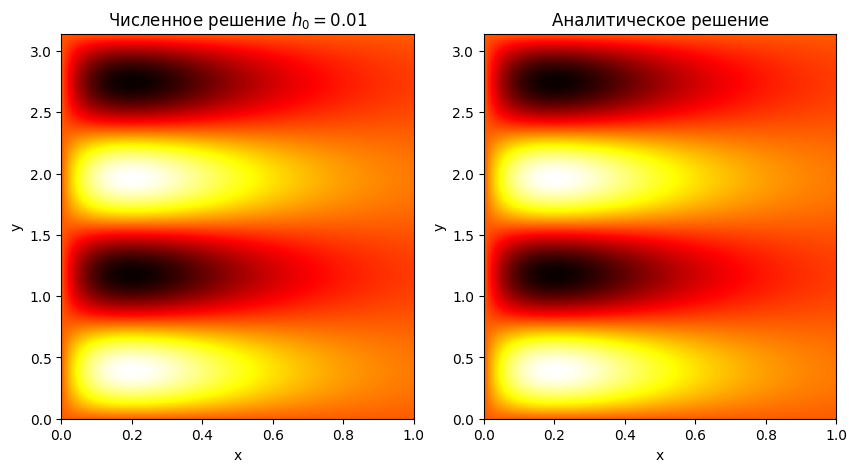

In [16]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
im1 = ax1.imshow(u.T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f'Численное решение $h_0 = ${h_0}')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(analitical(X, Y).T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title("Аналитическое решение")

plt.show()

Посмотрим на карту ошибок

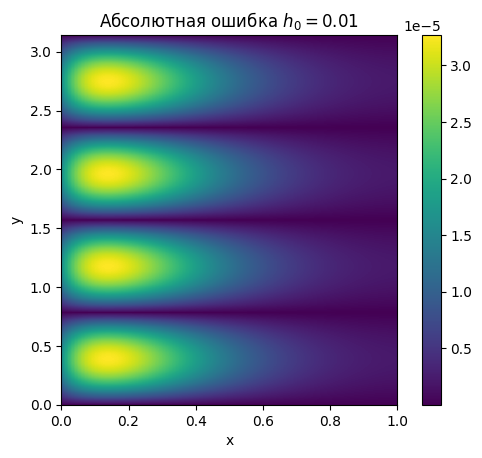

In [17]:
im1 = plt.imshow(np.abs((u - analitical(X, Y)).T), origin='lower', extent=(0, l_x, 0, l_y), aspect=0.35)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Абсолютная ошибка $h_0 = ${h_0}')
plt.colorbar(im1)

plt.show()

Исследуем зависимость ошибки от шага

In [18]:
steps = [0.5, 0.1, 0.07, 0.05, 0.02, 0.01]
errs = []
for h_i in steps:
    n_x, n_y = int(np.round(l_x / h_i)), int(np.round(l_y / h_i))
    h_x, h_y = l_x / n_x, l_y / n_y
    x = np.linspace(h_x / 2, l_x - h_x / 2, n_x)
    y = np.linspace(h_y / 2, l_y - h_y / 2, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    u = np.zeros_like(X) # начальное приближение
    epsilon = 1e-6
    F = RHS(X, Y, h_x, h_y)
    r = OpL(u, h_x, h_y) - F

    while np.abs((r**2).sum() > epsilon):
        Lr = OpL(r, h_x, h_y)
        u += Lr.ravel().dot(r.ravel()) / LA.norm(Lr)**2 * (F - OpL(u, h_x, h_y))
        u -= u.mean() # нормировка
        r = OpL(u, h_x, h_y) - F

    errs.append(np.max(np.abs(u - analitical(X, Y))))

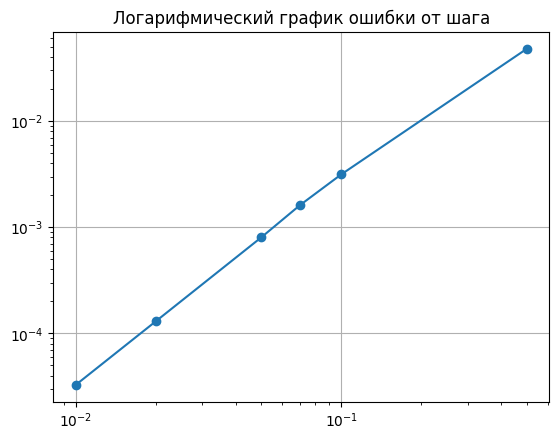

In [19]:
plt.loglog(steps, errs, marker='o')
plt.title("Логарифмический график ошибки от шага")
plt.grid(True)
plt.show()

Из графика видно, что порядок аппроксимации близок к 2

Теперь посмотрим, как ошибка падает в процессе итераций

In [29]:
# в конце цикла рассчета ошибок h принял значение 0.01 будем работать с ним

u = np.zeros_like(X) # начальное приближение
epsilon = 1e-6
r = OpL(u, h_x, h_y) - RHS(X, Y, h_x, h_y)
iter_num = 1
errs = [np.max(np.abs(analitical(X, Y) - u))]

F = RHS(X, Y, h_x, h_y)
r = OpL(u, h_x, h_y) - F

while np.abs((r**2).sum() > epsilon):
    Lr = OpL(r, h_x, h_y)
    u += Lr.ravel().dot(r.ravel()) / LA.norm(Lr)**2 * (F - OpL(u, h_x, h_y))
    u -= u.mean() # нормировка
    r = OpL(u, h_x, h_y) - F
    iter_num += 1
    errs.append(np.max(np.abs(u - analitical(X, Y))))

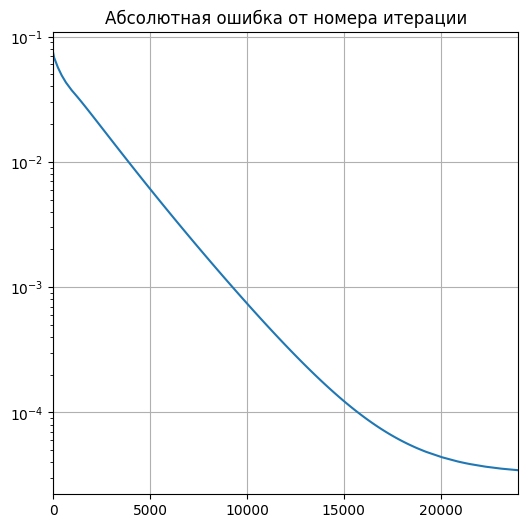

In [30]:
plt.figure(figsize=(6, 6))
plt.semilogy(range(1, iter_num + 1), errs)
plt.xlim(0, 24000)
plt.title("Абсолютная ошибка от номера итерации")
plt.grid()
plt.show()

Оценим параметр $q$

$$ ||u^k - u||_L \leqslant q^k||u^0 - u||_L$$

$$ \displaystyle q \geqslant \left(\frac{||u^k - u||_L}{||u^0 - u||_L}\right)^\frac{1}{k}$$

$$ ||v||_L = \sqrt{(Lv, v)} $$

Начальное приближение было выбрано 0, поэтому формула приобретет несколько упрощенный вид

$$ \displaystyle q \geqslant \left(\frac{||u^k - u||_L}{||u||_L}\right)^\frac{1}{k}$$

In [31]:
u = np.zeros_like(X) # начальное приближение
epsilon = 1e-6
r = OpL(u, h_x, h_y) - RHS(X, Y, h_x, h_y)
iter_num = 1
qs = [np.power(np.sqrt((OpL(u - analitical(X, Y), h_x, h_y) * (u - analitical(X, Y))).sum() \
                       / (OpL(analitical(X, Y), h_x, h_y) * analitical(X, Y)).sum()), 1 / iter_num)]

F = RHS(X, Y, h_x, h_y)
r = OpL(u, h_x, h_y) - F

while np.abs((r**2).sum() > epsilon):
    Lr = OpL(r, h_x, h_y)
    u += Lr.ravel().dot(r.ravel()) / LA.norm(Lr)**2 * (F - OpL(u, h_x, h_y))
    u -= u.mean() # нормировка
    r = OpL(u, h_x, h_y) - F
    iter_num += 1
    qs.append(np.power(np.sqrt((OpL(u - analitical(X, Y), h_x, h_y) * (u - analitical(X, Y))).sum() \
                       / (OpL(analitical(X, Y), h_x, h_y) * analitical(X, Y)).sum()), 1 / iter_num))

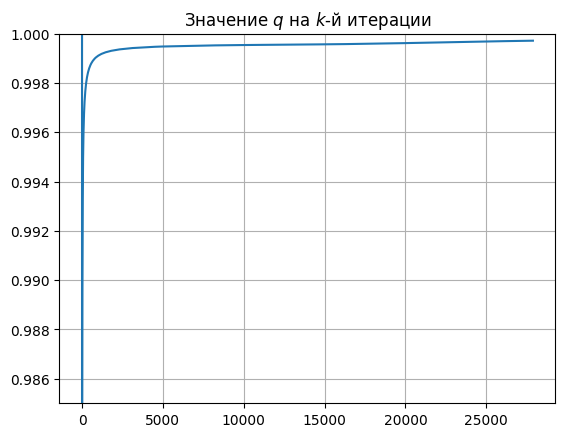

In [32]:
plt.plot(range(1, iter_num + 1), qs)
plt.grid(True)
plt.title("Значение $q$ на $k$-й итерации")
plt.ylim(0.985, 1)
plt.show()